In [53]:
# Installing Hugging Face's nlp packages
!pip install nlp

In [56]:
 # Importing all the libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
%matplotlib inline

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


In [57]:
dataset = nlp.load_dataset('emotion') # Imprting the Tweet Emotion dataset

Using custom data configuration default


In [58]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [59]:
train = dataset['train']
val = dataset['validation'] # Creating train, validation and test sets
test = dataset['test']

In [60]:
def get_tweets(data):
    tweets = [x['text'] for x in data]  # Extracting the tweet and label data
    labels = [x['label'] for x in data]
    return tweets, labels

In [61]:
tweets, labels = get_tweets(train)

In [63]:
tweets[0:4], labels[0:4]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'],
 ['sadness', 'sadness', 'anger', 'love'])

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [64]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>') # Adding a numeric value to the most common words

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[1]]))

[[2, 40, 101, 60, 8, 15, 494, 5, 15, 3496, 553, 32, 60, 61, 128, 148, 76, 1480, 4, 22, 1255]]


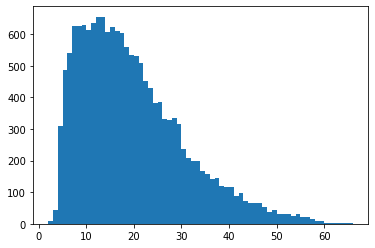

In [66]:
lengths = [len(x.split(' ')) for x in tweets] # Checking lengths of the tweets

plt.hist(lengths, bins=len(set(lengths))) # Visualizing the length of a tweet
plt.show()

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [72]:
def get_sequences(tokenizer, tweets): # Padding and Truncating Sequences
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=55, padding='post')
    return padded_sequences

In [73]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [74]:
padded_train_sequences[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [75]:
classes = set(labels)
print(classes)

{'anger', 'fear', 'love', 'sadness', 'surprise', 'joy'}


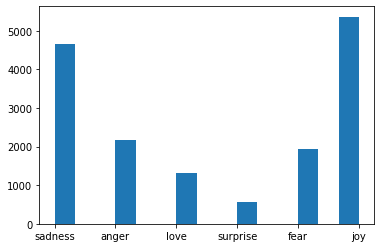

In [77]:
plt.hist(labels, bins=15)
plt.show() # Visualizing tweets number

In [78]:
classes_to_index = dict((c, i) for i, c in enumerate(classes)) # Indexing classes to a num
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [79]:
classes_to_index

{'anger': 0, 'fear': 1, 'joy': 5, 'love': 2, 'sadness': 3, 'surprise': 4}

In [80]:
index_to_classes

{0: 'anger', 1: 'fear', 2: 'love', 3: 'sadness', 4: 'surprise', 5: 'joy'}

In [82]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels]) # Adding numeric id 

In [83]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


In [85]:
# Creating and Compiling the Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(100000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            1600000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 246       
Total params: 1,615,926
Trainable params: 1,615,926
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Validating data and training the model
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [88]:
val_tweets[0:4], val_labels[0:4]

(['im feeling quite sad and sorry for myself but ill snap out of it soon',
  'i feel like i am still looking at a blank canvas blank pieces of paper',
  'i feel like a faithful servant',
  'i am just feeling cranky and blue'],
 array([3, 3, 2, 0]))

In [89]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 20s 31ms/step - loss: 1.3749 - accuracy: 0.4171 - val_loss: 1.0470 - val_accuracy: 0.5870
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.8526 - accuracy: 0.6562 - val_loss: 0.7803 - val_accuracy: 0.6820
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.5843 - accuracy: 0.7801 - val_loss: 0.6037 - val_accuracy: 0.7920
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3821 - accuracy: 0.8754 - val_loss: 0.5306 - val_accuracy: 0.8255
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2933 - accuracy: 0.9029 - val_loss: 0.4938 - val_accuracy: 0.8305
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2516 - accuracy: 0.9149 - val_loss: 0.5229 - val_accuracy: 0.8415
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.1740 - accuracy: 0.9442 - val_loss: 0.5115 - val_accuracy:

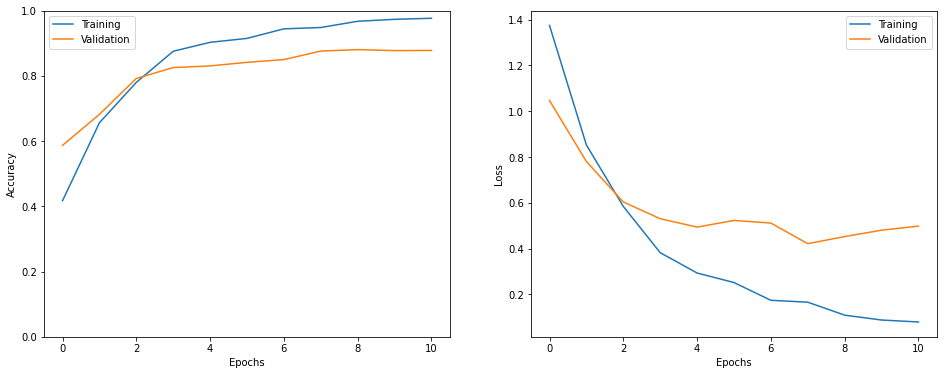

In [90]:
# Visualizing training history and Preparing a test
show_history(h)

In [91]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [92]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4907 - accuracy: 0.8750


In [93]:
i = random.randint(0, len(test_labels) - 1) # Prediction with random data

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i get people asking me what it feels like to be the most hated man in dallas county said assessor steve helm
Emotion: sadness


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted Emotion: anger


In [94]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


((2000,), (2000,))

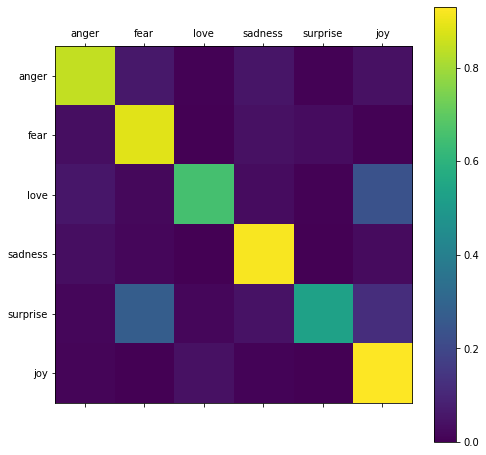

In [95]:
show_confusion_matrix(test_labels, preds, list(classes)) # Visualizing the prediction